In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#import pytz
import scipy
import requests
import warnings
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

import extract_nba_rolling_stats

# Parameters and Data

In [ ]:
def pull_preprocess_data(rolling_period = 62,
                         stat_cats = ['pts']):
    user_params = extract_nba_rolling_stats\
                      .UserParameters(rolling_period = rolling_period,
                                     stat_cats = stat_cats)
    
    def split_train_test(data):
        split_date = data['game_date'].unique()[int(len(data['game_date'].unique()) * 0.7)]
    
        train = data[data['game_date'] <= split_date]
        test = data[data['game_date'] > split_date]
    
        # Independent and Dependent variables
        X_cols = [col for col in data.columns if ((col == 'min')
                                                  | (('player_' in col)
                                                     & ('_mean' in col))
                                                  # | ('_stand' in col)
                                                 )
                 ]
        y_cols = [col for col in data.columns if '_normed' in col]
    
        # Training set
        X_train = train[X_cols].dropna()
        y_train = train.loc[X_train.index,
                            y_cols]
    
        # Test set
        X_test = test[X_cols].dropna()
        y_test = test.loc[X_test.index,
                        y_cols]
    
        return X_train, X_test, y_train, y_test

    
    extracted_data = extract_nba_rolling_stats\
                            .run_extract(roll_period = rolling_period,
                                         categories = stat_cats)\
                            .extracted_data
    
    rolling_data = extract_nba_rolling_stats\
                    .get_rolling_stats(original_data = extracted_data,
                                       p = user_params
                                      )

    standardized_data = extract_nba_rolling_stats\
                            .standardize_data(rolling_data,
                                              user_params.stat_cats)

    
    for cat in stat_cats:
        standardized_data[cat+'_normed'] = standardized_data[cat].apply(lambda x: (x**(1/2)).real)
        
        # Remove Outliers
        third_quart = np.percentile(standardized_data[cat], 75, method='midpoint')
        first_quart = np.percentile(standardized_data[cat], 25, method='midpoint')

        interquartile_range = third_quart - first_quart
        
        upper = third_quart + (1.5*interquartile_range)

        standardized_data.drop(standardized_data[standardized_data[cat] > upper].index,
                 inplace = True)

        # Normalize Data
        standardized_data[cat+'_normed'] = standardized_data[cat].apply(lambda x: (x**(1/2)).real)

        # Categorize if average was met by player
        standardized_data[cat+'_avg_met'] = (standardized_data['fpts'] >= standardized_data['player_fpts_mean']).apply(int)

    standardized_data['min_stand'] = standardized_data['min'].apply(lambda x: (x - standardized_data['min'].mean())/(standardized_data['min'].std()))

    # Dummify Data
    data_dummied = pd.get_dummies(data = standardized_data.dropna(how = 'any'),
                              columns= ['player_position'],
                              dtype = int)

    X_train, X_test, y_train, y_test = split_train_test(data_dummied)
    
    return data_dummied#X_train, X_test, y_train, y_test

In [ ]:
for i in [10,15,20]:
    data = pull_preprocess_data(rolling_period = i,
                                stat_cats = ['fpts'])

    excel_path = '/'.join(['.','Data',
                            'modeling_data_%i rp_fpts.xlsx' %i])

    with pd.ExcelWriter(excel_path) as writer:
        data.to_excel(writer,
                      index = False)

# Pipeline

## Model Metrics

In [2]:
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
ran_state = 130

In [9]:
def split_train_test(data):

    unique_game_dates = data[data['game_date'] >= '2022-01-01']['game_date'].unique()

    # Take 2023 and beyond to adjust for the rolling statistic
    split_date = unique_game_dates[int(len(unique_game_dates) * 0.7)]
    
    train = data[data['game_date'] <= split_date]
    test = data[data['game_date'] > split_date]
        
        # Independent and Dependent variables
    ## Complete
    # ((col == 'min')
    #   | (('opponent_team_opp_' in col)
    #      & ('_stand' in col))
    #  )
    # ((col == 'min')
    #   | (('opponent_team_opp_' in col)
    #      & ('_pg' in col))
    #  )
    ## Try
    # ((('player_' in col)
    #    & ('mean' in col)
    #    & ('league' not in col))
    #   | (('opponent_team_opp_' in col)
    #      & ('_pg' in col))
    #  )
    X_cols = [col for col in data.columns if ((('_mean_stand' in col)
                                               & ('league' not in col))
                                              | (col == 'min_stand')
                                              # | (('team_' in col)
                                              #    & ('_pg_stand' in col)
                                              #    & ('opp_' not in col))
                                              | (('opponent_team_opp_pos_' in col)
                                                 & ('_pg' in col)
                                                & ('_stand' in col))
                                             )
             ]
    y_cols = [col for col in data.columns if (('_normed' in col)
                                              & ('_scaled' not in col))]
    
    # Training set
    X_train = train[X_cols].dropna()
    y_train = train.loc[X_train.index,
                        y_cols]
    
    # Test set
    X_test = test[X_cols].dropna()
    y_test = test.loc[X_test.index,
                    y_cols]
    
    return X_train, X_test, y_train, y_test

## Neural Network (sklearn)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

In [ ]:
nn_regress = MLPRegressor(random_state = ran_state,
                         early_stopping = True)

### RandomSearchCV

In [ ]:
nn_performances = pd.DataFrame()

for p in [60,15,30,82]:
    print('Rolling period = %i' %p)

    # Read in data
    print('Reading data...')
    excel_path = '/'.join(['.','Data',
                            'modeling_data_%i rp_fpts.xlsx' %p])

    data = pd.read_excel(excel_path,
                         header = 0)

    # Train-test split
    X_train, X_test, y_train, y_test = split_train_test(data)

    print(*X_train.columns, sep = ', ')
    print(*y_train.columns, sep = ', ')
    
    # Randomized Search CV
    print('Performing RandomSearchCV...')
    ran_hidden_layers = [(5,2),
                         (5,5,2),
                         (2,5,2),
                         (3,3,3),
                         (10,5,2),
                         (3,3,3,3,3)]
    ran_activation = ['relu','logistic']
    ran_learning_rate = [0.001, 0.01, 0.1, 0.0001]
    
    ran_nn_params = {'hidden_layer_sizes':ran_hidden_layers,
                     'activation':ran_activation,
                    'learning_rate_init':ran_learning_rate}

    nn_regress_ranCV = RandomizedSearchCV(nn_regress,
                                          ran_nn_params,
                                          n_iter = 15,
                                         cv = 3,
                                         random_state = ran_state,
                                         verbose = 3)

    nn_regress_ranCV.fit(X_train,
                         y_train)

    ran_cv_performance = pd.DataFrame(nn_regress_ranCV.cv_results_).sort_values('rank_test_score')

    ran_cv_performance['rolling_period'] = p

    nn_performances = pd.concat([nn_performances,
                                 ran_cv_performance])

# Writer RandomSearchCV performance to excel
print('Writing results to Excel...')
ran_cv_performance_excel_path = '/'.join(['.','Data',
                                        'Random Search CV Performance_nn regressor.xlsx'])

with pd.ExcelWriter(ran_cv_performance_excel_path, mode = 'a') as writer:
    nn_performances.to_excel(writer,
                                sheet_name = 'FPTS No Team Pos-less',
                                index = False)

In [ ]:
best_model = nn_regress_ranCV.best_estimator_

In [ ]:
y_pred_nn_ranCV = pd.DataFrame(best_model.predict(X_test),
                      columns = ['fpts_normed'])

In [ ]:
y_test['fpts'] = y_test['fpts_normed'].apply(lambda x: x**2)
y_pred_nn_ranCV['fpts'] = y_pred_nn_ranCV['fpts_normed'].apply(lambda x: x**2)

In [ ]:
mse = mean_squared_error(y_test[['fpts']],
                         y_pred_nn_ranCV[['fpts']],
                        squared = False)

r_squared = r2_score(y_test[['fpts']],
                     y_pred_nn_ranCV[['fpts']])

print('Root Mean Squared Error = %f' %mse)
print('R Squared = %f' %r_squared)

# Residual plot
residuals_rf = y_test['fpts'].values - y_pred_nn_ranCV['fpts'].values
print('Sum of residuals = %f' %sum(residuals_rf))

## Neural Network (keras)

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model

In [6]:
tf.random.set_seed(ran_state)
tf.keras.utils.set_random_seed(ran_state)
np.random.seed(ran_state)

Rolling period = 15
Reading data...
Splitting data...
opponent_team_opp_pos_fpts_pg_stand, fpts_mean_stand, min_stand
fpts_normed
Building NN...
Epoch 1/500
116/116 [==============================] - 5s 10ms/step - loss: 6.3246 - val_loss: 1.1382
Epoch 2/500
116/116 [==============================] - 1s 8ms/step - loss: 0.7908 - val_loss: 0.8549
Epoch 3/500
116/116 [==============================] - 1s 11ms/step - loss: 0.7382 - val_loss: 0.8198
Epoch 4/500
116/116 [==============================] - 1s 9ms/step - loss: 0.7207 - val_loss: 0.8048
Epoch 5/500
116/116 [==============================] - 1s 12ms/step - loss: 0.7183 - val_loss: 0.7844
Epoch 6/500
116/116 [==============================] - 1s 12ms/step - loss: 0.7141 - val_loss: 0.8080
Epoch 7/500
116/116 [==============================] - 1s 9ms/step - loss: 0.7157 - val_loss: 0.7965
Epoch 8/500
116/116 [==============================] - 1s 10ms/step - loss: 0.7133 - val_loss: 0.7881
Epoch 9/500
116/116 [=====================

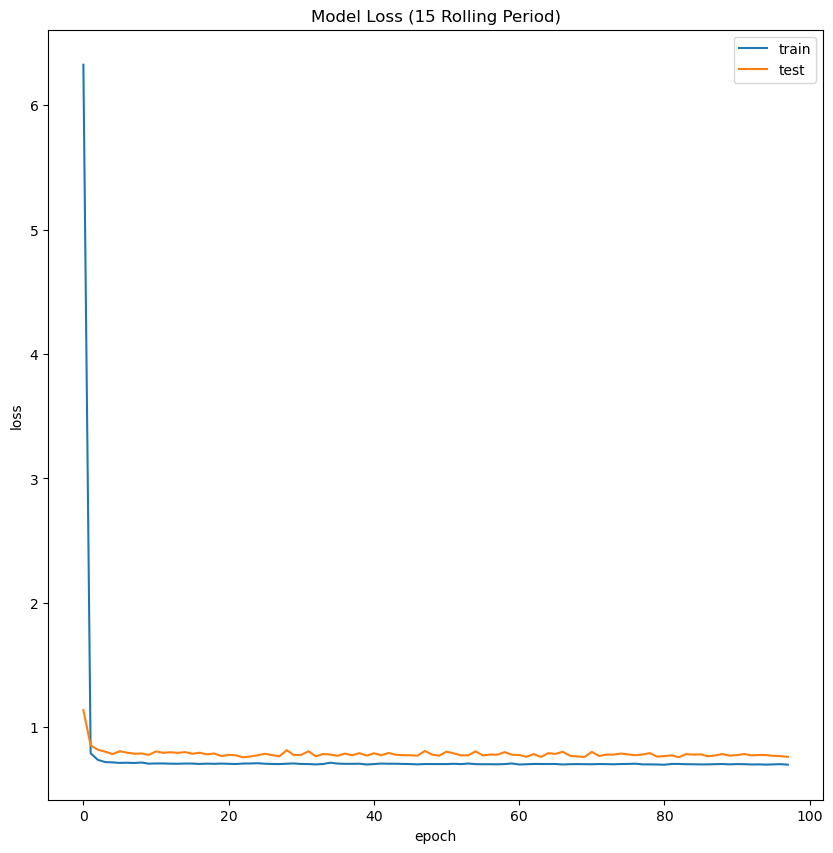

Minimum validation MSE: 0.758560


In [10]:
nn_performances = pd.DataFrame()

for p in [15]:
    print('Rolling period = %i' %p)

    # Read in data
    print('Reading data...')
    excel_path = '/'.join(['.','Data',
                            'modeling_data_%i rp_fpts.xlsx' %p])

    data = pd.read_excel(excel_path,
                         header = 0)

    print('Splitting data...')
    # Train-test split
    X_train, X_test, y_train, y_test = split_train_test(data)

    print(*X_train.columns, sep = ', ')
    print(*y_train.columns, sep = ', ')

    print('Building NN...')
    # Define keras NN model
    nn_regress_model = Sequential()

    nn_regress_model.add(Dense(50,
                               input_shape=(len(X_train.columns),),
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(50,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(50,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(50,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(50,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(20,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(20,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(10,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(10,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(5,
                               activation = 'relu')
                        )
    nn_regress_model.add(Dense(1,
                               activation = 'relu')
                         )

    # Compile model
    nn_regress_model.compile(loss = 'mean_squared_error',
                             optimizer = 'adam',
                             # metrics = ['mse',
                             #            # 'R2Score'
                             #           ]
                            )

    # Instansiate Early Stopping
    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   mode = 'min', # Searches for minimum val_loss (mse)
                                   patience = 75,
                                   # min_delta = 1,
                                   # verbose = 1
                                  )
    # Fit model
    nn_regress_history = nn_regress_model.fit(X_train,
                                              y_train,
                                              validation_split = 0.3,
                                              epochs = 500,
                                              batch_size = 256,
                                              callbacks = [early_stopping],
                                              verbose = 1
                                             )
    
    print('Exporting model...')
    model_file_name = 'nn_regress_fpts_(50,50,50,50,50,20,20,10,10,5)_%i rp' %p
    
    model_json = nn_regress_model.to_json()
    with open('./Models/%s.json' %model_file_name,'w') as json_file:
        json_file.write(model_json)

    nn_regress_model.save_weights('./Models/%s.h5' %model_file_name)

    # Plot training loss
    fig, ax = plt.subplots(figsize = (10,10))
    plt.plot(nn_regress_history.history['loss'])
    plt.plot(nn_regress_history.history['val_loss'])
    plt.title('Model Loss (%i Rolling Period)' %p)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train','test'])
    plt.show()

    print('Minimum validation MSE: %f' %min(nn_regress_history.history['val_loss']))

In [ ]:
# 10, 10, 10, 5
val_loss_60 = 0.828070
val_loss_15 = 0.756364
val_loss_30 = 0.756917
val_loss_82 = 0.759453

# 30, 30, 20, 20, 10, 10, 5, 5
val_loss_60 = 0.754236
val_loss_15 = 0.752914
val_loss_30 = 0.756710
val_loss_82 = 0.756727

# 50, 50, 50, 50, 50, 20, 10, 5
val_loss_60 = 0.752826
val_loss_15 = 0.751323
val_loss_30 = 0.755012
val_loss_82 = 0.753004
c
# 50, 50, 50, 50, 50, 20, 20, 10, 10, 5
val_loss_10 = 0.756129
val_loss_15 = 0.750552
val_loss_20 = 0.754744

# 20, 50, 100, 100, 50, 20, 20, 10, 10, 5
val_loss_15 = 0.753080

# 50, 50, 50, 50, 50, 20, 20, 20, 10, 10, 10, 5
val_loss_15 = 0.753343

# 50, 50, 50, 50, 50, 50, 20, 10, 10, 5
val_loss_15 = 0.751529

# 50, 50, 50, 50, 50, 20, 20, 10, 10, 5, 5
val_loss_15 = 0.751529

# 50, 50, 50, 50, 50, 25, 10, 5, 20, 10, 3
val_loss_15 = 0.752131

# Best Model

In [11]:
import json
from keras.models import model_from_json

best_model = model_from_json(open('./Models/nn_regress_fpts_(50,50,50,50,50,20,20,10,10,5)_15 rp.json').read())

best_model.load_weights('./Models/nn_regress_fpts_(50,50,50,50,50,20,20,10,10,5)_15 rp.h5')

In [12]:
excel_path = '/'.join(['.','Data',
                        'modeling_data_15 rp_fpts.xlsx'])

data = pd.read_excel(excel_path,
                     header = 0)

In [13]:
X_train, X_test, y_train, y_test = split_train_test(data)

In [14]:
y_pred_nn = pd.DataFrame(best_model.predict(X_test),
                      columns = ['fpts_normed'])

491/491 [==============================] - 2s 3ms/step


In [15]:
y_test['fpts'] = y_test['fpts_normed'].apply(lambda x: x**2)
y_pred_nn['fpts'] = y_pred_nn['fpts_normed'].apply(lambda x: x**2)

In [16]:
mse_normed = mean_squared_error(y_test[['fpts_normed']],
                         y_pred_nn[['fpts_normed']],
                        squared = True)

rmse = mean_squared_error(y_test[['fpts']],
                         y_pred_nn[['fpts']],
                        squared = False)

r_squared = r2_score(y_test[['fpts']],
                     y_pred_nn[['fpts']])

print('Normed MSE = %f' %mse_normed)
print('Root Mean Squared Error = %f' %rmse)
print('R Squared = %f' %r_squared)

# Residual plot
residuals_rf = y_test['fpts'].values - y_pred_nn['fpts'].values
print('Sum of residuals = %f' %sum(residuals_rf))

Normed MSE = 0.773658
Root Mean Squared Error = 7.676846
R Squared = 0.711146
Sum of residuals = 18177.699240


<Axes: xlabel='fpts', ylabel='fpts'>

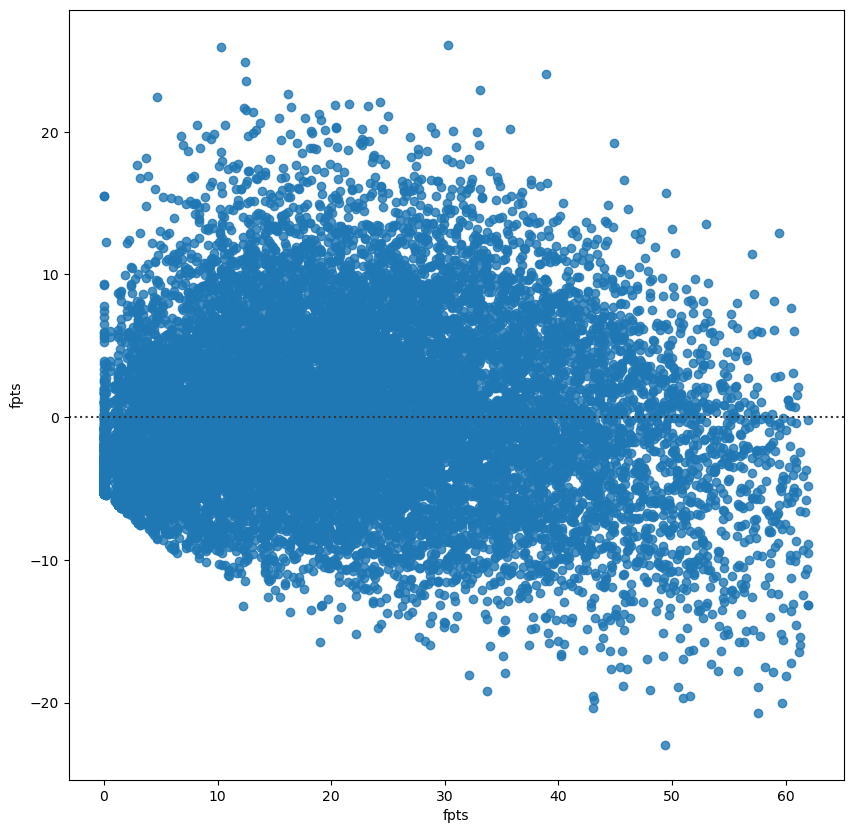

In [17]:
fig, ax = plt.subplots(figsize = (10,10))
sns.residplot(x = y_test['fpts'],
             y = y_pred_nn['fpts'])